In [1]:
# import sys
# print(sys.path)
# sys.path.append('/lib/python3.7/site-packages')
# from PIL import Image
# import torch
# torch.cuda.device(0)

# torch.cuda.get_device_name(0)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.imports import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [2]:
# The metadata is indexed by the objid
df_INFO = pd.read_csv('./128pix_Train30K/128px_Train30k.csv')
print(df_INFO.shape)
df_INFO.head()

(30000, 6)


,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,FileNames
0,1237662474235085097,1.076603,9.267565e+09,291.857134,43.540800,1237662474235085097.png
1,1237662473689956770,3.543734,5.527158e+10,661.714311,90.031951,1237662473689956770.png
2,1237662266464272761,1.080237,3.812792e+09,212.999997,25.240952,1237662266464272761.png
3,1237662305116750294,0.954058,4.078536e+09,190.714289,24.216386,1237662305116750294.png
4,1237656496724836598,4.237423,7.537444e+10,509.571433,61.791850,1237656496724836598.png


In [3]:
Base_dir =f'./128pix_Train30K/'

In [7]:
df_INFO.head()

,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,FileNames
0,1237662474235085097,1.076603,9.267565e+09,291.857134,43.540800,1237662474235085097.png
1,1237662473689956770,3.543734,5.527158e+10,661.714311,90.031951,1237662473689956770.png
2,1237662266464272761,1.080237,3.812792e+09,212.999997,25.240952,1237662266464272761.png
3,1237662305116750294,0.954058,4.078536e+09,190.714289,24.216386,1237662305116750294.png
4,1237656496724836598,4.237423,7.537444e+10,509.571433,61.791850,1237656496724836598.png


In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 128
sz = 128

In [5]:
data_stellar_image = ( 
    ImageList.from_df(df_INFO, Base_dir, cols=['FileNames'])
        .split_by_rand_pct(0.2, seed=42)
        .label_from_df("M/L",label_cls=FloatList).transform(tfms, padding_mode='border',size=sz)
        .databunch(bs=64,num_workers=0).normalize(xGASS_stats) 
                      )

(Image (3, 128, 128), FloatItem 2.0767674)


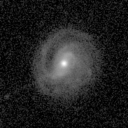

In [6]:
print(data_stellar_image.valid_ds[0])
data_stellar_image.valid_ds[0][0]

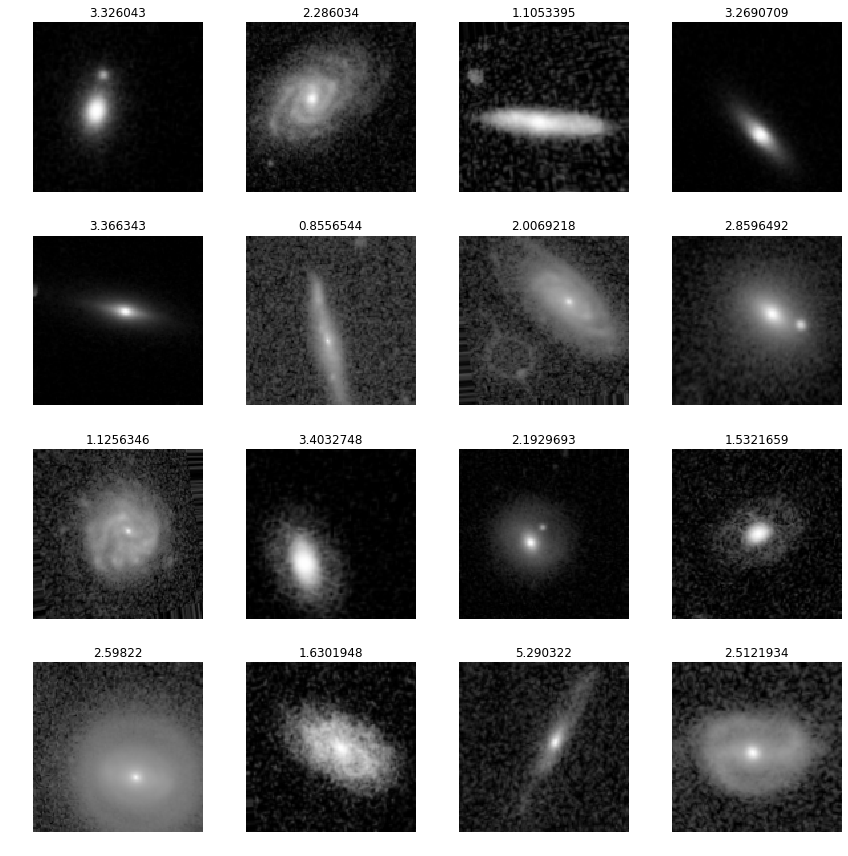

In [7]:
data_stellar_image.show_batch(4,figsize=(12,12))

In [7]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-5)
class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, in1:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(in1.view(-1), target.view(-1))

In [8]:
learn = Learner(data_stellar_image, model=models.xresnet152(), 
                opt_func=opt_func,
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )


In [9]:
learn.model[-1] = nn.Linear(2048, 1, bias=True).cuda()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.02E-02


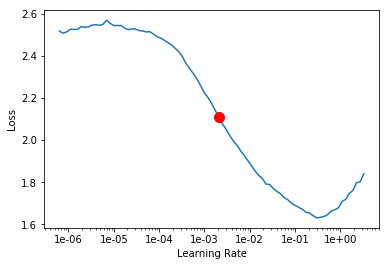

In [10]:
# learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [11]:
learn.fit_one_cycle(5, 1e-2, pct_start=0.1, callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,time
0,1.071582,1.186497,09:05
1,1.051967,1.054606,09:20
2,1.020609,1.167701,09:19
3,1.018710,1.074760,08:54
4,0.990129,1.003527,08:51


Better model found at epoch 0 with valid_loss value: 1.186497449874878.
Better model found at epoch 1 with valid_loss value: 1.0546057224273682.
Better model found at epoch 4 with valid_loss value: 1.0035268068313599.


In [15]:
learn.save('first_head_resnet150_517_1')

In [52]:
learn.load('first_head_resnet150_517_1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 7.59E-08


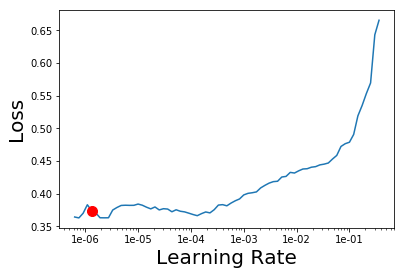

In [53]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.350633,0.320543,0.904298,09:17
1,0.359216,0.336125,0.932959,09:17
2,0.346994,0.318935,0.902773,09:32
3,0.335170,0.312012,0.892205,09:32
4,0.330104,0.306524,0.883736,09:43


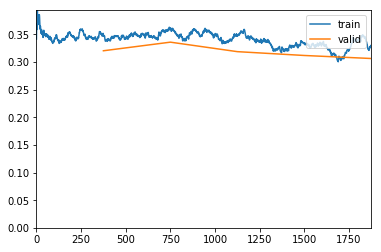

Better model found at epoch 0 with valid_loss value: 0.32054269313812256.
Better model found at epoch 2 with valid_loss value: 0.3189351558685303.
Better model found at epoch 3 with valid_loss value: 0.3120119869709015.
Better model found at epoch 4 with valid_loss value: 0.3065238296985626.


In [54]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4), wd=(1e-6, 1e-4, 1e-2), 
                    callbacks=[SaveModelCallback(learn)], pct_start=0.5)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.321150,0.320420,0.917336,09:21
1,0.329065,0.306316,0.886537,09:19
2,0.323208,0.321808,0.904130,09:17
3,0.326086,0.303671,0.872584,09:41
4,0.304023,0.296432,0.862999,09:33


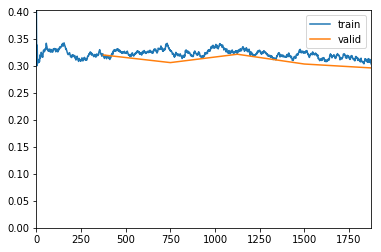

Better model found at epoch 0 with valid_loss value: 0.3204200565814972.
Better model found at epoch 1 with valid_loss value: 0.3063164949417114.
Better model found at epoch 3 with valid_loss value: 0.303670734167099.
Better model found at epoch 4 with valid_loss value: 0.29643189907073975.


In [55]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4), wd=(1e-6, 1e-4, 1e-2), 
                    callbacks=[SaveModelCallback(learn)], pct_start=0.5)

In [56]:
learn.save('second_head_resnet150_517_2')

In [70]:
learn.export("RESNET_STELAR_FINAL_517best_best.pkl")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type L1LossFlat. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluation on Validation set

In [57]:
p_val, y_val = learn.TTA()

# p_val,y_val = learn.get_preds(ds_type=DatasetType.Valid)

print(p_val.shape),print(y_val.shape)

pval_numpy = p_val.numpy()
y_val_numpy =  y_val.numpy()

print(pval_numpy.shape),print(y_val_numpy.shape)

torch.Size([6000, 1])
torch.Size([6000])
(6000, 1)
(6000,)


(None, None)

In [42]:
# learn =  load_learner(load_path,"RESNET_STELAR_FINAL_517best_best.pkl")

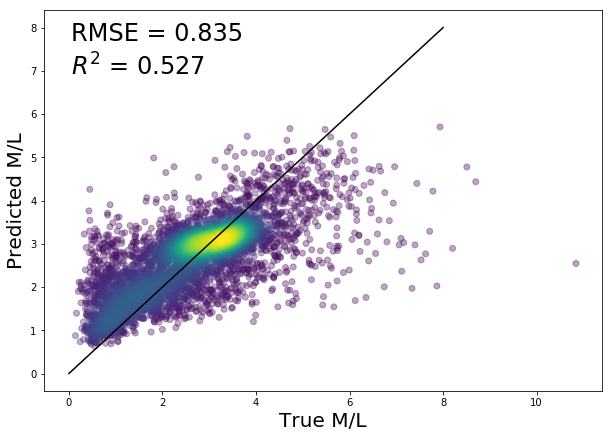

In [59]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = y_val_numpy
    y_pred = pval_numpy[:,0]
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()

# Evalution on test set

In [60]:
test_dir =f'./128_test5K/'

In [61]:
df_test =  pd.read_csv(os.path.join(test_dir,"128_test5k.csv"))

In [62]:
df_test.head()

,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,FileNames
0,1237667323264892995,2.655465,5.694904e+10,323.571414,40.150990,1237667323264892995.png
1,1237667322714652800,0.757768,2.382490e+09,89.999999,13.426679,1237667322714652800.png
2,1237668310557589844,1.080746,2.730325e+09,195.857137,24.303315,1237668310557589844.png
3,1237662226217762902,1.708090,3.609239e+10,300.428580,39.945456,1237662226217762902.png
4,1237667211587026970,2.966155,2.124328e+10,219.857145,27.916868,1237667211587026970.png


In [64]:
data_test_stellar_image = ImageList.from_df(df_test, test_dir, cols=['FileNames']).split_by_rand_pct(1.0, seed=42).label_from_df("M/L",label_cls=FloatList).transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border',size=128).databunch(bs=64,num_workers=0).normalize(imagenet_stats)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [65]:
learn.data = data_test_stellar_image

In [66]:
learn.data

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: FloatList

Path: 128_test5K;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: FloatList
1.9010245,2.6855159,1.9699476,3.024144,3.3240407
Path: 128_test5K;

Test: None

In [67]:
p_test, y_test = learn.TTA()

# p_val,y_val = learn.get_preds(ds_type=DatasetType.Valid)

print(p_test.shape),print(y_test.shape)

ptest_numpy = p_test.numpy()
y_test_numpy =  y_test.numpy()

print(ptest_numpy.shape),print(y_test_numpy.shape)

torch.Size([5000, 1])
torch.Size([5000])
(5000, 1)
(5000,)


(None, None)

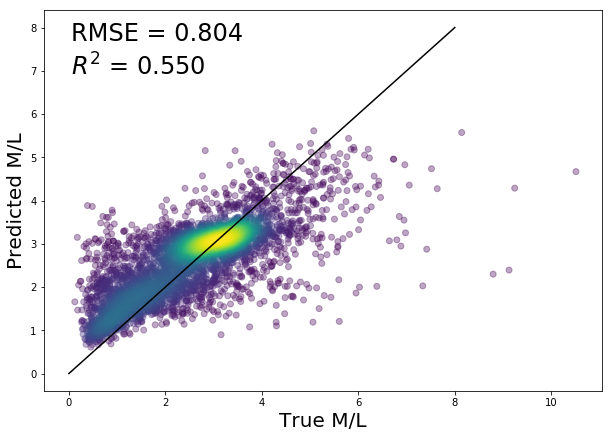

In [69]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = y_test_numpy
    y_pred = ptest_numpy[:,0]
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()